# Assignment2

Imports

In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import random
from sklearn.impute import KNNImputer
import time


Import the data

In [413]:
df = pd.read_csv(r"employees.csv")

Display

In [414]:
display(df)
df=df.head(500)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## 3.1 Anonymisation: Bare Bones

Text(0.5, 1.0, 'Cardinality')

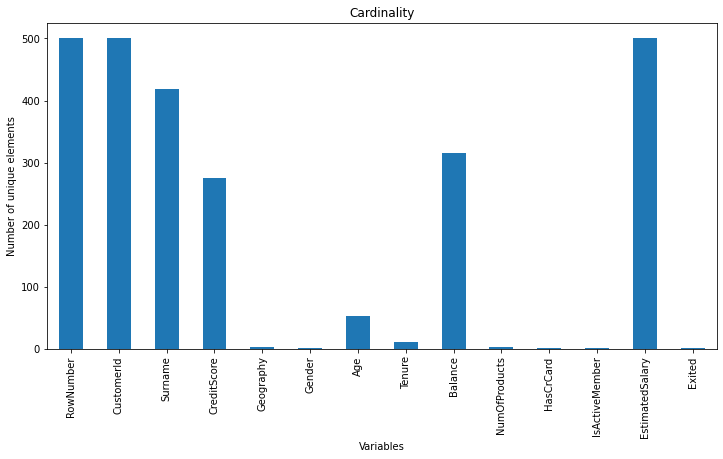

In [415]:
df.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique elements')
plt.xlabel('Variables')
plt.title('Cardinality')

#### Quassi Idetifiers Combination values uniqueness

In [416]:
display(df.groupby(['Gender','Age','Geography']).size().reset_index(name='count'))

,Gender,Age,Geography,count
0,Female,21,France,3
1,Female,21,Spain,1
2,Female,22,France,1
3,Female,22,Spain,2
4,Female,23,France,1
...,...,...,...,...
193,Male,62,Spain,1
194,Male,65,France,1
195,Male,67,Germany,1
196,Male,68,France,1


#### k anonymity using selective suppression and generalization

In [417]:
def k_anonymity_generalization(data, k, quassi_identifiers):
    anonymized_data = data.copy()

    #generalize
    round(anonymized_data['Age'],-1)
    
    
    for column in quassi_identifiers:
        grouped_data = anonymized_data.groupby(['Age', 'Gender', 'Geography']).size().reset_index(name='count')

        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['Age', 'Gender', 'Geography']]

        for _, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['Age'] == row['Age']) & \
                   (anonymized_data['Geography'] == row['Geography']) & \
                   (anonymized_data['Gender'] == row['Gender'])

            if mask.any():
                if len(anonymized_data[mask]) < k:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data


quassi_identifiers = ['Age', 'Gender', 'Geography']

k_anonymized_generalization = k_anonymity_generalization(df, k=4, quassi_identifiers=quassi_identifiers)

### Quassi Idetifiers Combination values uniqueness

In [418]:
counts=k_anonymized_generalization.groupby(['Age','Gender', 'Geography']).size().reset_index(name='count')
print("Anonymized:")
display(counts[counts['count']>0])

Anonymized:


,Age,Gender,Geography,count
0,26,Male,Germany,5
1,29,Female,Germany,4
2,29,Male,France,5
3,29,Male,Spain,5
4,30,Female,France,4
5,30,Female,Germany,4
6,30,Male,France,7
7,31,Female,France,6
8,31,Male,France,5
9,31,Male,Germany,4


## 3.2 Anonymising your dataset

### Approach 1 add KNN

In [419]:
def knn_impute_age(data, k):
    data_copy = data.copy()
    age_data = data_copy[['Age']].copy()
    knn_imputer = KNNImputer(n_neighbors=k)
    age_data['Age'] = knn_imputer.fit_transform(age_data[['Age']])
    age_data['Age'] = pd.cut(age_data['Age'].squeeze(), bins=k)
    age_data['Age'] = age_data['Age'].astype(str)
    data_copy['Age'] = age_data['Age']
    anonymised=k_anonymity(data_copy,4,[ 'Gender', 'Geography'])
    return anonymised

def k_anonymity(data, k, quassi_identifiers):
    anonymized_data = data.copy()
    
    for column in quassi_identifiers:
        grouped_data = anonymized_data.groupby(['Age', 'Gender', 'Geography']).size().reset_index(name='count')

        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['Age', 'Gender', 'Geography']]

        for _, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['Age'] == row['Age']) & \
                   (anonymized_data['Geography'] == row['Geography']) & \
                   (anonymized_data['Gender'] == row['Gender'])

            if mask.any():
                if len(anonymized_data[mask]) < k:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data

knn_anonymised = knn_impute_age(df, k=4)
print(knn_anonymised)


     RowNumber  CustomerId       Surname  CreditScore Geography  Gender  \
0            1    15634602      Hargrave          619    France  Female   
1            2    15647311          Hill          608     Spain  Female   
2            3    15619304          Onio          502    France  Female   
3            4    15701354          Boni          699    France  Female   
4            5    15737888      Mitchell          850     Spain  Female   
..         ...         ...           ...          ...       ...     ...   
495        496    15804256          Hale          765   Germany    Male   
496        497    15662403      Kryukova          622    France  Female   
497        498    15733616  Sopuluchukwu          806    France    Male   
498        499    15591995         Barry          757   Germany    Male   
499        500    15677020     Selezneva          570    France  Female   

                 Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0      (34.25, 49.5]       2  

In [420]:
counts=knn_anonymised.groupby(['Age','Gender', 'Geography']).size().reset_index(name='count')
print("Anonymized:")
display(counts[counts['count']>0])

Anonymized:


,Age,Gender,Geography,count
0,"(18.939, 34.25]",Female,France,42
1,"(18.939, 34.25]",Female,Germany,27
2,"(18.939, 34.25]",Female,Spain,21
3,"(18.939, 34.25]",Male,France,47
4,"(18.939, 34.25]",Male,Germany,27
5,"(18.939, 34.25]",Male,Spain,31
6,"(34.25, 49.5]",Female,France,46
7,"(34.25, 49.5]",Female,Germany,29
8,"(34.25, 49.5]",Female,Spain,36
9,"(34.25, 49.5]",Male,France,69


### Approach 2 add l-diversity

In [421]:
def calculate_l_diversity_within_groups(sensitive_columns, l, k_anonymized):
   grouped_data=k_anonymized.groupby( ['Age','Gender', 'Geography'])
    
   
   for _, group in grouped_data:
       for column in sensitive_columns:
           if group[column].nunique() < l:
                return False
   return True

def l_diversity(l,k_anonymized):
    grouped_data=k_anonymized.groupby( ['Age','Gender', 'Geography'])
   
    for _, group_rows in grouped_data:
        while group_rows['Balance'].nunique() < l:
            random_row_index = random.choice(group_rows.index)
            noise = np.random.normal(loc=0.0, scale=300)
            group_rows.loc[random_row_index, 'Balance'] +=noise
            k_anonymized.loc[random_row_index, 'Balance'] +=noise
        while group_rows['EstimatedSalary'].nunique() < l:
            random_row_index = random.choice(group_rows.index)
            noise = np.random.normal(loc=0.0, scale=300)
            group_rows.loc[random_row_index, 'EstimatedSalary'] +=noise
            k_anonymized.loc[random_row_index, 'EstimatedSalary'] +=noise
            
    return k_anonymized


quasi_identifiers_to_group_by = ['Age','Gender', 'Geography']
sensitive_column_to_anonymize = ['Balance','EstimatedSalary']
desired_l_diversity_within_groups = 3

if calculate_l_diversity_within_groups(sensitive_column_to_anonymize, desired_l_diversity_within_groups,k_anonymized_generalization):
    print("Already satisfies l-diversity")
else:
    print("Anonymizing dataset to ensure l-diversity")
    anonymized_dataset = l_diversity(desired_l_diversity_within_groups,k_anonymized_generalization)
    display("Anonymized dataset:", anonymized_dataset)
    print("satisfies: ",calculate_l_diversity_within_groups(sensitive_column_to_anonymize, desired_l_diversity_within_groups,k_anonymized_generalization))

Anonymizing dataset to ensure l-diversity


'Anonymized dataset:'

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,*,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,*,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,*,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,15804256,Hale,765,Germany,Male,36,8,92310.54,2,1,1,72924.56,0
496,497,15662403,Kryukova,622,France,Female,32,6,169089.38,2,1,0,101057.95,0
497,498,15733616,Sopuluchukwu,806,France,Male,40,5,80613.93,1,1,1,142838.64,0
498,499,15591995,Barry,757,Germany,Male,26,8,121581.56,2,1,1,127059.04,0


satisfies:  True


## 3.3 Compartmentation and Clustering

##### Combine age and gender with a higher weight on age
##### You can adjust the weight based on your preference

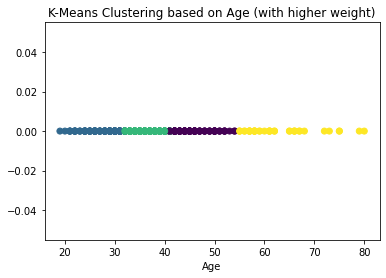

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,weighted_features,cluster,generalized_age
0,1,15634602,Hargrave,619,France,Female,45.931034,2,0.00,1,1,1,101348.88,1,17.1,0,45.931034
1,2,15647311,Hill,608,Spain,Female,44.470588,1,83807.86,1,0,1,112542.58,0,16.7,0,44.470588
2,3,15619304,Onio,502,France,Female,45.931034,8,159660.80,3,1,0,113931.57,1,17.1,0,45.931034
3,4,15701354,Boni,699,France,Female,35.925000,1,0.00,2,0,0,93826.63,0,15.9,2,35.925000
4,5,15737888,Mitchell,850,Spain,Female,44.470588,2,125510.82,1,1,1,79084.10,0,17.5,0,44.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,15804256,Hale,765,Germany,Male,37.066667,8,92310.54,2,1,1,72924.56,0,14.4,2,37.066667
496,497,15662403,Kryukova,622,France,Female,35.925000,6,169089.38,2,1,0,101057.95,0,13.1,2,35.925000
497,498,15733616,Sopuluchukwu,806,France,Male,36.606557,5,80613.93,1,1,1,142838.64,0,16.0,2,36.606557
498,499,15591995,Barry,757,Germany,Male,27.565217,8,121581.56,2,1,1,127059.04,0,10.4,1,27.565217


In [422]:
def kmeans_anonymise(k,data):
    kmeans_anonymised_df=data.copy()
    kmeans_anonymised_df['weighted_features'] = 0.4 * kmeans_anonymised_df['Age'] + 0.4 * (kmeans_anonymised_df['Geography'] == 'Female').astype(int)+ 0.3 * (kmeans_anonymised_df['Gender'] == 'Female').astype(int)

    X = kmeans_anonymised_df['weighted_features'].values.reshape(-1, 1)

    # Apply KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_anonymised_df['cluster'] = kmeans.fit_predict(X)

    plt.scatter(kmeans_anonymised_df['Age'], np.zeros_like(kmeans_anonymised_df['Age']), c=kmeans_anonymised_df['cluster'], cmap='viridis')
    plt.xlabel('Age')
    plt.title('K-Means Clustering based on Age (with higher weight)')
    plt.show()



    # Generalize age within each cluster based on gender
    clustered_data = kmeans_anonymised_df.groupby(['cluster', 'Gender','Geography'])['Age'].mean().reset_index()
    clustered_data.rename(columns={'Age': 'generalized_age'}, inplace=True)

    # Merge the generalized age information back into the original DataFrame
    kmeans_anonymised_df = pd.merge(kmeans_anonymised_df, clustered_data,on=['cluster', 'Gender','Geography'], how='left')
    kmeans_anonymised_df['Age']=kmeans_anonymised_df['generalized_age']
    
    return kmeans_anonymised_df

kmeans_anonymised_df=kmeans_anonymise(4,df)

display(kmeans_anonymised_df)

## 3.4 Testing Data Utility

In [423]:
def measure_utility(original_data, anonymized_data):
    precision_age = original_data['Age'].mean() / anonymized_data['Age'].replace('*', np.nan).astype(float).mean()

    original_geography_count = len(original_data['Geography'].unique())
    anonymized_geography_count = len(anonymized_data['Geography'].unique())
    diversity_ratio = anonymized_geography_count / original_geography_count

    info_loss_salary = np.abs(original_data['EstimatedSalary'] - anonymized_data['EstimatedSalary'].astype(float)).mean()
   
    correlation_original = original_data[['Age', 'EstimatedSalary']].replace('*', np.nan).astype(float).corr().iloc[0, 1]
    correlation_anonymized = anonymized_data[['Age', 'EstimatedSalary']].replace('*', np.nan).astype(float).corr().iloc[0, 1]

    print("Accuracy of Analysis (Correlation) Age and salary",correlation_original)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(original_data['Age'], bins=20, color='blue', alpha=0.7, label='Original Data')
    plt.title('Original Dataset - Age Histogram')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(anonymized_data['Age'].replace('*', np.nan).astype(float), bins=20, color='green', alpha=0.7, label='Anonymized Data')
    plt.title('Anonymized Dataset - Age Histogram')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()


    utility_report = {
        'Precision Loss (Age)': precision_age,
        'Diversity and Variability (Geography)': diversity_ratio,
        'Information Loss sensitive attribute(Balance)': info_loss_salary,
        'Accuracy of Analysis (Correlation)': correlation_anonymized,
    }

    return utility_report

##### 3.1 Utility measure precision of generalization, diversity and variability, Information Loss numerical columns, Accuracy of Analysis (Correlation between 'Age' and 'Salary') and visual inspection (histogram comparison)

Accuracy of Analysis (Correlation) Age and salary -0.009147418121896119


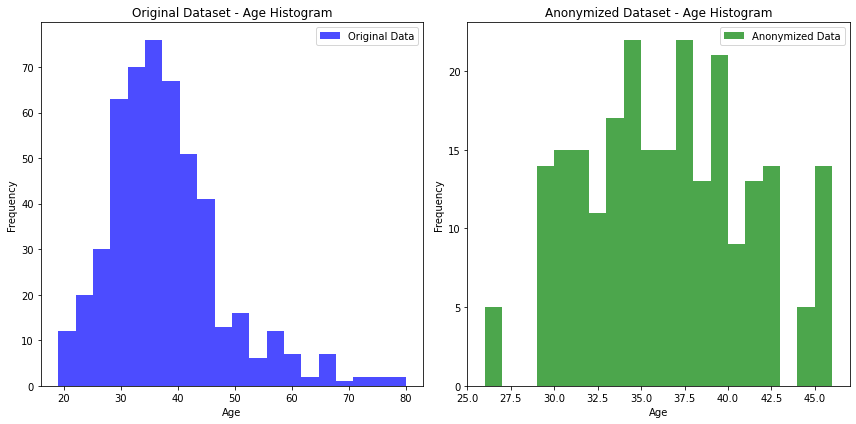


Precision Loss (Age): 1.0580101804720037

Diversity and Variability (Geography): 1.0

Information Loss sensitive attribute(Balance): 0.0

Accuracy of Analysis (Correlation): 0.029618101246985724


In [424]:

# Measure utility
utility_metrics = measure_utility(df, k_anonymized_generalization)

# Print utility metrics
for metric, value in utility_metrics.items():
    print(f"\n{metric}: {value}")

##### 3.2 1

In [425]:
frequency_df = knn_anonymised['Age'].value_counts().reset_index().rename(columns={'index': 'AgeVal', 'Age': 'Frequency'})


ranges = frequency_df['AgeVal'].tolist()
frequencies = frequency_df['Frequency'].tolist()
lower_bounds, upper_bounds = zip(*[map(float, s.strip('()[]').split(',')) for s in ranges])

midpoints = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

weighted_mean = np.average(midpoints, weights=frequencies)

weighted_std = np.sqrt(np.average((midpoints - weighted_mean)**2, weights=frequencies))

print(f"Ranges: {ranges}")
print(f"Frequencies: {frequencies}")
print(f"\nAnonymized Weighted Mean: {weighted_mean}")
print(f"Anonymized Weighted Standard Deviation: {weighted_std}")



frequency_df_original = df['Age'].value_counts().reset_index().rename(columns={'index': 'AgeVal', 'Age': 'Frequency'})
ranges_original = frequency_df_original['AgeVal'].tolist()
frequencies_original = frequency_df_original['Frequency'].tolist()
original_mean = np.average(ranges_original, weights=frequencies_original)
original_std = np.sqrt(np.average((ranges_original - original_mean)**2, weights=frequencies_original))

print(f"\nOriginal Mean: {original_mean}")
print(f"Original Standard Deviation: {original_std}")

print('Precision Loss (Age):',original_mean/weighted_mean)

Ranges: ['(34.25, 49.5]', '(18.939, 34.25]', '(49.5, 64.75]', '(64.75, 80.0]']
Frequencies: [248, 195, 43, 14]

Anonymized Weighted Mean: 38.081104999999994
Anonymized Weighted Standard Deviation: 11.077737631234772

Original Mean: 38.106
Original Standard Deviation: 9.945187982134877
Precision Loss (Age): 1.000653736282075


Accuracy of Analysis (Correlation) Age and salary -0.009147418121896119


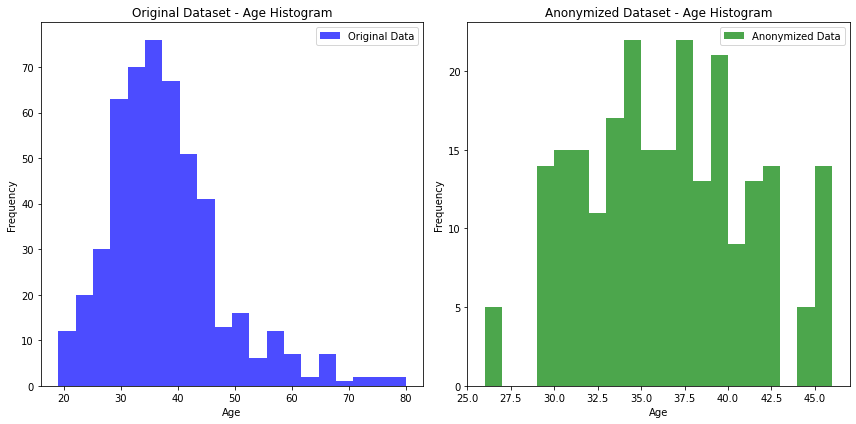


Precision Loss (Age): 1.0580101804720037

Diversity and Variability (Geography): 1.0

Information Loss sensitive attribute(Balance): 0.0

Accuracy of Analysis (Correlation): 0.029618101246985724


In [426]:

# Measure utility
utility_metrics = measure_utility(df, anonymized_dataset)

# Print utility metrics
for metric, value in utility_metrics.items():
    print(f"\n{metric}: {value}")

##### 3.3

Accuracy of Analysis (Correlation) Age and salary -0.009147418121896119


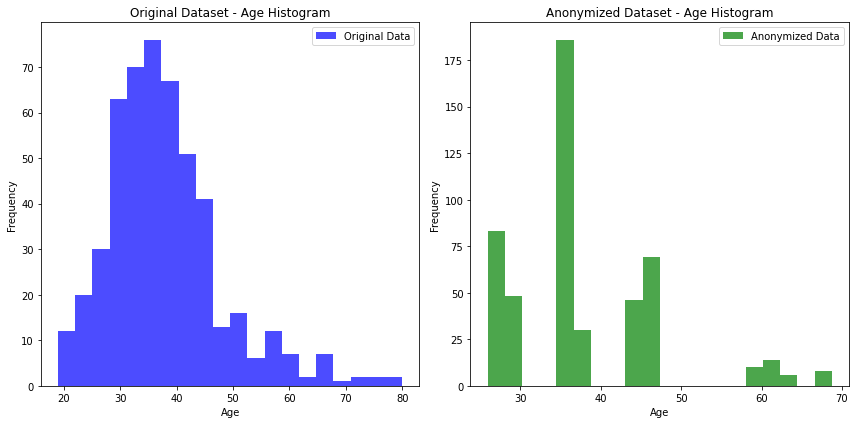


Precision Loss (Age): 1.0

Diversity and Variability (Geography): 1.0

Information Loss sensitive attribute(Balance): 0.0

Accuracy of Analysis (Correlation): -0.025840305259863285


In [427]:

# Measure utility
utility_metrics = measure_utility(df, kmeans_anonymised_df)

# Print utility metrics
for metric, value in utility_metrics.items():
    print(f"\n{metric}: {value}")

### 3.4 3 Execution time

3.1

In [428]:
dataset_sizes = [100, 500, 3000,5000,10000]
execution_times = []

for size in dataset_sizes: 
    larger_data =pd.read_csv(r"employees.csv").head(size)
    start_time = time.time()
    k_anonymity_generalization(larger_data, 4, ['Age','Gender', 'Geography'])
    end_time = time.time()
    execution_time = end_time-start_time;
    execution_times.append(execution_time)

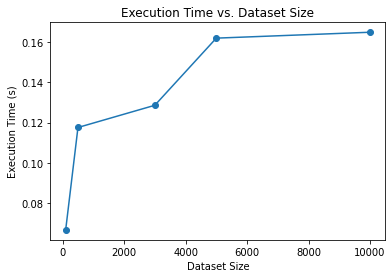

In [429]:
plt.plot(dataset_sizes, execution_times, marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Dataset Size')
plt.show()

3.2 1

In [430]:
dataset_sizes = [100, 500, 3000,5000,10000]
execution_times = []

for size in dataset_sizes: 
    larger_data =pd.read_csv(r"employees.csv").head(size)
    start_time = time.time()
    knn_impute_age(larger_data, k=4)
    end_time = time.time()
    execution_time = end_time-start_time;
    execution_times.append(execution_time)

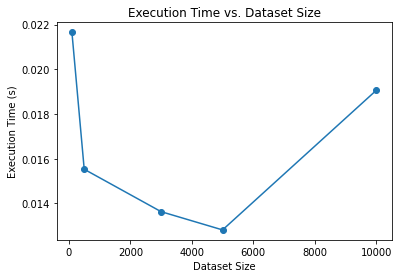

In [431]:
plt.plot(dataset_sizes, execution_times, marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Dataset Size')
plt.show()

In [435]:
dataset_sizes = [100, 500, 3000,5000,10000]
execution_times = []

for size in dataset_sizes: 
    larger_data =pd.read_csv(r"employees.csv").head(size)
    start_time = time.time()
    k_anon=knn_impute_age(larger_data, k=4)
    l_diversity(2,k_anon)
    end_time = time.time()
    execution_time = end_time-start_time;
    execution_times.append(execution_time)

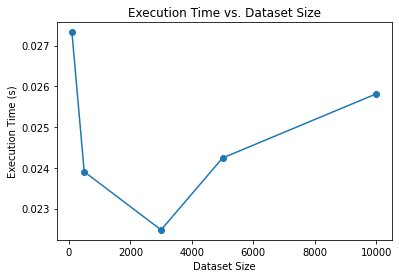

In [436]:
plt.plot(dataset_sizes, execution_times, marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Dataset Size')
plt.show()

In [450]:
dataset_sizes = [100, 500, 3000,5000,10000]
execution_times = []

for size in dataset_sizes: 
    larger_data =pd.read_csv(r"employees.csv").head(size)
    start_time = time.time()
    kmeans_anonymised_df
    end_time = time.time()
    execution_time = end_time-start_time;
    execution_times.append(execution_time)

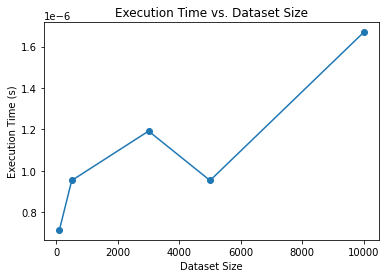

In [451]:
plt.plot(dataset_sizes, execution_times, marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Dataset Size')
plt.show()

dataset_sizes = [100, 500, 3000,5000,10000]
execution_times = []

for size in dataset_sizes: 
    larger_data =pd.read_csv(r"employees.csv").head(size)
    start_time = time.time()
    l(larger_data, k=4)
    end_time = time.time()
    execution_time = end_time-start_time;
    execution_times.append(execution_time)